In [1]:
import pymongo
import pandas as pd
import numpy as np

from pymongo import MongoClient
from bson.objectid import ObjectId

import datetime

import matplotlib.pyplot as plt

from collections import defaultdict


%matplotlib inline
import json
plt.style.use('ggplot')

import seaborn as sns

from math import log10, floor

In [2]:
## Connect to local DB

client = MongoClient('localhost', 27017)
print ("Setup db access")

Setup db access


In [3]:
#
# Get collections from mongodb
#
#db = client.my_test_db
db = client.test


In [4]:
chunk = 100000
start = 0
end = start + chunk

In [5]:
reponses = db.anon_student_task_responses.find({'correct':False})[start:end]

In [6]:
df_responses = pd.DataFrame(list(reponses))

In [7]:
print (df_responses.head())

                        _id behavioral_traits  bonus  correct      diff  \
0  5a00f1739100de1a390000e7                []  False    False  0.284006   
1  5a00f1739100de1a390000ea                []  False    False  0.168491   
2  5a00f1739100de1a39000108                []  False    False  0.159949   
3  5a00f1739100de1a3900010d                []  False    False  0.569281   
4  5a00f1739100de1a39000128   [hops_vs_ticks]  False    False  0.000000   

           id  incomplete           lesson  \
0  39Y1vECA2c       False  review_lesson_4   
1  faYl5HT_Sn       False  review_lesson_4   
2  jGq7IGYWTF       False  review_lesson_1   
3  gM26ScOfQr       False  review_lesson_1   
4  iFYu9imr7r       False         nline_1a   

                                       level_summary  \
0  {'subject': 'review', 'unit_name': '', 'title'...   
1  {'subject': 'review', 'unit_name': '', 'title'...   
2  {'type': 'lesson', 't_elapsed': 193872, 'descr...   
3  {'type': 'lesson', 't_elapsed': 193872, 'desc

In [8]:
df_responses.shape

(100000, 27)

In [9]:
df2 = df_responses.join(pd.DataFrame(df_responses["student"].to_dict()).T)

In [10]:
df2 = df2.join(pd.DataFrame(df2['level_summary'].to_dict()).T)

In [11]:
df2 = df2.join(pd.DataFrame(df2['problems'].to_dict()).T)

In [12]:
df3  = df2.copy()

In [13]:
## Look act columns
print (df_responses.columns)

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched'],
      dtype='object')


In [14]:
## How many data samples
print (len(df_responses), "Number of entries")

100000 Number of entries


In [15]:
## Make 'description' a feature wih important words mapped

In [16]:
df3.columns

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched', 'grade',
       'mvt_group', 'mvt_group_code', 'school_id', 'section_id', 'student_id',
       'blank_slate_mastery', 'description', 'entered', 'lesson_type',
       'lm_stats', 'mastery', 'name', 'path', 'problems', 'stars', 'subject',
       't_elapsed', 'time_entered', 'time_exited', 'title', 'type',
       'unit_name', 'unit_rank', 'nretry_right', 'nretry_wrong', 'nright',
       'ntotal', 'nuntouched', 'nwrong'],
      dtype='object')

In [17]:
df3['percent_correct'] = df3['nright'].astype(float) / df3['ntotal']

In [18]:
df3.iloc[0]

_id                                              5a00f1739100de1a390000e7
behavioral_traits                                                      []
bonus                                                               False
correct                                                             False
diff                                                             0.284006
id                                                             39Y1vECA2c
incomplete                                                          False
lesson                                                    review_lesson_4
level_summary           {'subject': 'review', 'unit_name': '', 'title'...
problem_set             lessons/fractions/lesson10/quarters_ab/quarter...
problem_set_id                                                 BYGzN1ZApc
problem_set_subspace                                                 set2
qual_id                                        BYGzN1ZApc.set2.39Y1vECA2c
randomly_selected                     

In [19]:
for idx in range(100):
    print ('index"', idx)
    print (df3.iloc[idx]['lesson'])
    print (df3.iloc[idx]['response'])

index" 0
review_lesson_4
None
index" 1
review_lesson_4
None
index" 2
review_lesson_1
{'plain_image_groups': [{'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/objects/shark.swf'}, {'total': 1, 'url': 'assets/cms/wootmath_fractions/number_line/markers/start_marker.swf'}], 'fraction_cblock_containment': {}, 'input': '6', 'numberline_associations': [[{'position': 722, 'pos_value': 1.0028985507246377, 'obj_name': 'object', 'obj_value': None}]], 'fraction_cblock_chains': [{'sum': {'denominator': 1, 'numerator': 1, '__as3_type': 'Fraction'}, 'lcm_sum': {'denominator': 6, 'numerator': 6, '__as3_type': 'Fraction'}, 'pieces': ['1/6', '1/6', '1/6', '1/6', '1/6', '1/6'], 'left': 165, 'right': 856}], 'fraction_cblock_total_count': 6, 'fraction_cblock_counts': {'1/6': 6}}
index" 3
review_lesson_1
{'whole': '', 'fraction_input_value': '1/3', 'fraction_cblock_chains': [{'sum': {'denominator': 1, 'numerator': 1, '__as3_type': 'Fraction'}, 'lcm_sum': {'denominator': 3, 'numerator': 3, '__a

In [20]:
def stringify_response(resp):
    my_val = str(resp).replace("': ","_")
    my_val = my_val.replace("_{"," ")
    my_val = my_val.replace("_[",", ")
    for c in [']','[','{','}',"'","",","]:
        my_val = my_val.replace(c,'')
    return my_val


In [21]:
stringify_response(df3.iloc[0]['response'])

'None'

In [22]:
df3['response_str'] = df3['response'].apply(stringify_response)

In [23]:
for idx in range(20):
    print (idx, df3['response_str'].iloc[idx])

0 None
1 None
2 plain_image_groups total_1 url_assets/cms/wootmath_fractions/number_line/objects/shark.swf total_1 url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf fraction_cblock_containment  input_6 numberline_associations position_722 pos_value_1.0028985507246377 obj_name_object obj_value_None fraction_cblock_chains sum denominator_1 numerator_1 __as3_type_Fraction lcm_sum denominator_6 numerator_6 __as3_type_Fraction pieces 1/6 1/6 1/6 1/6 1/6 1/6 left_165 right_856 fraction_cblock_total_count_6 fraction_cblock_counts 1/6_6
3 whole_ fraction_input_value_1/3 fraction_cblock_chains sum denominator_1 numerator_1 __as3_type_Fraction lcm_sum denominator_3 numerator_3 __as3_type_Fraction pieces 1/3 1/3 1/3 left_96 right_657 fraction_cblock_containment  num_1 plain_image_groups total_1 url_assets/cms/wootmath_fractions/number_line/markers/end_marker.swf total_1 url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf total_1 url_assets/cms/wootmath_frac

In [24]:
df3.columns

Index(['_id', 'behavioral_traits', 'bonus', 'correct', 'diff', 'id',
       'incomplete', 'lesson', 'level_summary', 'problem_set',
       'problem_set_id', 'problem_set_subspace', 'qual_id',
       'randomly_selected', 'response', 'response_idx', 'retried',
       'screenshot_url', 'second_try', 'session_id', 'student', 'sublesson',
       't', 'time_spent', 'timestamp', 'txt', 'untouched', 'grade',
       'mvt_group', 'mvt_group_code', 'school_id', 'section_id', 'student_id',
       'blank_slate_mastery', 'description', 'entered', 'lesson_type',
       'lm_stats', 'mastery', 'name', 'path', 'problems', 'stars', 'subject',
       't_elapsed', 'time_entered', 'time_exited', 'title', 'type',
       'unit_name', 'unit_rank', 'nretry_right', 'nretry_wrong', 'nright',
       'ntotal', 'nuntouched', 'nwrong', 'percent_correct', 'response_str'],
      dtype='object')

In [25]:
## In Response:
### convert K, V, and all K_V into words in a text doc
### Then add text
### The add description


In [26]:
def make_string_from_list(key, elem_list):
    # Append key to each item in list
    ans = ''
    for elem in elem_list:
        ans += key + '_' + elem 
        
        

        
    

def make_string(elem, key=None, top=True):
    ans = ''
    if not elem:
        return ans
    if top:
        top = False
        top_keys = []
        for idx in range(len(elem.keys())):
            top_keys.append(True)
            
    for idx, key in enumerate(elem.keys()):
        if top_keys[idx]:
            top = True
            top_keys[idx] = False
            ans += ' '
        else:
            top = False
        #print ('ans = ', ans)
        #print (type(elem[key]))
        if type(elem[key]) is str or\
                type(elem[key]) is int:
            #print ('add value', elem[key])
            value = str(elem[key])
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        elif type(elem[key]) is list:
            #print ('add list', elem[key])
            temp_elem = dict()
            for item in elem[key]:
                temp_elem[key] = item
                ans += make_string(temp_elem, top) 
        elif type(elem[key]) is dict:
            #print ('add dict', elem[key])
            for item_key in elem[key].keys():
                temp_elem = dict()
                temp_elem[item_key] = elem[key][item_key]
                ans += key + '_' + make_string(temp_elem, top)
        elif type(elem[key]) is float:
            #print ('add dict', elem[key])
            sig = 2
            value = elem[key]
            value = round(value, sig-int(
            floor(log10(abs(value))))-1)
            value = str(value)
            #ans += key + '_' + value + ' ' + value + ' '
            ans += key + '_' + value + ' '
        # ans += ' ' + key + ' '
        #print ('not handled', elem[key])
     
        
    return ans
        
            
            

In [27]:
df3['response_doc'] = df3['response'].map(make_string)

In [28]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')

In [29]:
df3['response_doc'] = df3['response_doc'] + df3['txt'] 

In [30]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x + ' ')

In [31]:
df3['response_doc'] = df3['response_doc'] +  df3['description']

In [32]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("\n", ""))

In [33]:
df3['response_doc'] = df3['response_doc'].map(lambda x: x.replace("?", " "))

In [34]:
df3.iloc[100]['response_doc']

'  plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/objects_v2/shark_goggles.swf plain_image_groups_ total_1  plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf plain_image_groups_ total_1  input_11    numberline_associations_ position_570.0 numberline_associations_ numberline_associations_ obj_name_object numberline_associations_ pos_value_0.71  The shark swam 5 tenths of a mile from the start, and thenswam back 2 tenths of a mile. Drag the shark to its final location.Answer: 3/10 A review of material from earlier lessons. The following topics were selected for review: Labeling Tenths on the Number Line; Locating Tenths on the Number Line; and Composing Decimals on the Number Line'

In [35]:
df3.iloc[100]['response']

{'input': '11',
 'numberline_associations': [[{'obj_name': 'object',
    'obj_value': None,
    'pos_value': 0.7128229702353126,
    'position': 572.5612903225807}]],
 'plain_image_groups': [{'total': 1,
   'url': 'assets/cms/wootmath_fractions/number_line/objects_v2/shark_goggles.swf'},
  {'total': 1,
   'url': 'assets/cms/wootmath_fractions/number_line/markers/start_marker.swf'}]}

In [36]:
for idx in range(20):
    print (idx, df3['response_doc'].iloc[idx])

0  Shade 1/4 of the circle.answer={:n=>3, :d=>12} A review of material from earlier lessons. The following topics were selected for review: One Fourth of Shapes and Sets - Supplemental 1; One Fourth of Shapes and Sets; and Equivalent Fractions in Partitioning Sets.
1  Shade 1/3 of the rectangle.answer={:n=>2, :d=>6} A review of material from earlier lessons. The following topics were selected for review: One Third of Shapes and Sets; One Fourth of Shapes and Sets; and Equivalent Fractions in Partitioning Sets.
2   plain_image_groups_ total_1 plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/objects/shark.swf  plain_image_groups_ total_1 plain_image_groups_ url_assets/cms/wootmath_fractions/number_line/markers/start_marker.swf   input_6    numberline_associations_ position_722 numberline_associations_ pos_value_1.0 numberline_associations_ obj_name_object numberline_associations_   fraction_cblock_chains_ sum_ denominator_1 sum_ numerator_1 sum_ __as3_type_Fraction fract

In [37]:
df3['response_doc'] = df3['response_doc'].map( lambda x: " ".join(x.split('/')) if '/' in x else x)

In [38]:
df3.iloc[100]['response_doc']

'  plain_image_groups_ url_assets cms wootmath_fractions number_line objects_v2 shark_goggles.swf plain_image_groups_ total_1  plain_image_groups_ url_assets cms wootmath_fractions number_line markers start_marker.swf plain_image_groups_ total_1  input_11    numberline_associations_ position_570.0 numberline_associations_ numberline_associations_ obj_name_object numberline_associations_ pos_value_0.71  The shark swam 5 tenths of a mile from the start, and thenswam back 2 tenths of a mile. Drag the shark to its final location.Answer: 3 10 A review of material from earlier lessons. The following topics were selected for review: Labeling Tenths on the Number Line; Locating Tenths on the Number Line; and Composing Decimals on the Number Line'

In [39]:
df3['response_doc'] = df3['response_doc'].map( lambda x: x.replace('[',' '))
df3['response_doc'] = df3['response_doc'].map( lambda x: x.replace(']',' '))

In [40]:
df3.iloc[100]['response_doc']

'  plain_image_groups_ url_assets cms wootmath_fractions number_line objects_v2 shark_goggles.swf plain_image_groups_ total_1  plain_image_groups_ url_assets cms wootmath_fractions number_line markers start_marker.swf plain_image_groups_ total_1  input_11    numberline_associations_ position_570.0 numberline_associations_ numberline_associations_ obj_name_object numberline_associations_ pos_value_0.71  The shark swam 5 tenths of a mile from the start, and thenswam back 2 tenths of a mile. Drag the shark to its final location.Answer: 3 10 A review of material from earlier lessons. The following topics were selected for review: Labeling Tenths on the Number Line; Locating Tenths on the Number Line; and Composing Decimals on the Number Line'

In [41]:
docs = list(df3['response_doc'])

In [42]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [43]:
data_samples = docs

In [44]:
n_features = 1000
n_samples = len(data_samples)
n_topics = 50
n_top_words = 20

In [45]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

Extracting tf-idf features for NMF...


In [46]:
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


done in 16.061s.


In [47]:
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


Extracting tf features for LDA...
done in 15.509s.


In [48]:
n_features = 1000
n_samples = len(data_samples)
n_topics = 50
n_top_words = 20

In [49]:
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))


Extracting tf-idf features for NMF...
done in 23.933s.
Extracting tf features for LDA...
done in 17.977s.


In [50]:

from sklearn.cluster import KMeans, MiniBatchKMeans
true_k = 100

km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)

In [51]:
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(tf)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=100, max_no_improvement=10,
        n_clusters=100, n_init=1, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=0)
done in 3.525s



In [52]:
print("Top terms per cluster:")


order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tf_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: fraction_cblock_chains_ pieces_1 lcm_sum_ sum_ __as3_type_fraction numerator_1 denominator_1 fraction_cblock_counts_ fraction 15
Cluster 1: fraction_cblock_chains_ sum_ lcm_sum_ numerator_1 __as3_type_fraction pieces_1 unit1_ denominator_6 denominator_2 left_175
Cluster 2: parts students answer lesson set shapes various symbols using fractional
Cluster 3: fraction_cblock_chains_ sum_ lcm_sum_ __as3_type_fraction numerator_1 pieces_1 denominator_1 left_60 denominator_8 bar3_
Cluster 4: numberline_associations_ plain_image_groups_ kangaroo line number_line number objects_v2 represent wootmath_fractions mile
Cluster 5: pieces_1 fraction_circle_groups_ lcm_sum_ sum_ chains_ __as3_type_fraction fraction scale_0 fraction_circle_counts_ fraction_circle_containment_
Cluster 6: fraction_cblock_chains_ sum_ lcm_sum_ __as3_type_fraction numerator_1 pieces_1 denominator_12 denominator_8 denominator_1 12
Cluster 7: pieces_1 fraction_cblock_chains_ lcm_sum_ sum_ __a

In [53]:
len(km.labels_)

100000

In [54]:
np.bincount(km.labels_)

array([  651,   128,   939,    10,   234,   710,   823,   126,  1681,
         403,   629,   366,   453,  1316,  1850,   948,   139,   136,
         369,  1271,    54,   802,    85,   318,  2086,  1375,    40,
         348,    54,   499,   569,   233,   492,   532,  2611,   134,
         540,   851,   288,   219,  1497,  3605,   960,  2553,   494,
         338,   196,  1234, 14880,  1106,  1313,  1015,   554,   366,
         581,    20,   142,   436,   339,     0,   802,  2032,  1129,
        1278,  2234,   405,  1645,   298,    70,    19,   268,  2831,
        1643,  1578,   169,    44,   470,   215,   449,   434,  1389,
        7157,  6659,   594,    75,   320,   756,   272,   292,  2821,
         257,    59,   561,   195,    65,  1013,  1344,   650,   298,   269])

In [55]:
df3['cluster_100'] = km.labels_

In [56]:
len(np.bincount(km.labels_))

100

In [57]:
df3['cluster_100'] = km.labels_


In [58]:
df3['trait_1'] = df3['behavioral_traits'].apply(lambda x : x[0] if len(x) > 0 else 'None' )

In [59]:
df3['trait_2'] = df3['behavioral_traits'].apply(lambda x : x[1] if len(x) > 1 else 'None' ) 

In [60]:
df3['trait_1'].value_counts()

None                             66277
inverts_numerator_denominator     5651
how_to_model                      4082
identifying_gt_lt                 3703
starting_from_0_nline             1782
counting_hops_not_ticks           1622
recognizing_the_whole             1371
deci_incorrect_inequality         1339
deci_understanding_gt_lt          1317
inequality_symbol                 1240
partially_drawn_parts             1132
dragging_to_add                    871
modeled_incorrect_comparison       837
partitioning_number_line           804
simplifying_bars_2                 790
deci_placing_decimal_points        595
misplaced_fraction_part_nline      538
simplifying_subtraction            523
measuring_tools                    517
hops_vs_ticks                      501
comparing_frac_gt_lt               473
only_tenths_entered                418
fraction_of_set                    371
multiplying_whole_by_proper        361
deci_forgot_decimal_point          291
simplify_with_common_deno

In [61]:
df3['trait_2'].value_counts()

None                            94762
equally_sized_parts              1132
modeled_incorrect_numerator       837
wrong_number_parts                804
simplifying_mixed_numbers         798
orange_tick                       517
simplifying_answers_nline         512
dragging_to_add_3_circles         262
nline_restart_one                 192
deci_break_tenths_hundredths      175
modulo_ans                          9
Name: trait_2, dtype: int64

In [62]:
df_cluster_100 = df3.groupby('cluster_100')

In [63]:
len(df_cluster_100)

99

In [64]:
df_cluster_100.head()

,_id,behavioral_traits,bonus,correct,diff,id,incomplete,lesson,level_summary,problem_set,...,nright,ntotal,nuntouched,nwrong,percent_correct,response_str,response_doc,cluster_100,trait_1,trait_2
0,5a00f1739100de1a390000e7,[],False,False,0.284006,39Y1vECA2c,False,review_lesson_4,"{'subject': 'review', 'unit_name': '', 'title'...",lessons/fractions/lesson10/quarters_ab/quarter...,...,1,4,1,3,0.250000,None,"Shade 1 4 of the circle.answer={:n=>3, :d=>12...",48,None,None
1,5a00f1739100de1a390000ea,[],False,False,0.168491,faYl5HT_Sn,False,review_lesson_4,"{'subject': 'review', 'unit_name': '', 'title'...",lessons/fractions/lesson11/thirds/media/proble...,...,0,3,4,3,0.000000,None,"Shade 1 3 of the rectangle.answer={:n=>2, :d=...",48,None,None
2,5a00f1739100de1a39000108,[],False,False,0.159949,jGq7IGYWTF,False,review_lesson_1,"{'type': 'lesson', 't_elapsed': 193872, 'descr...",lessons/fractions/lesson13_1/part_b/media/prob...,...,3,6,0,3,0.500000,plain_image_groups total_1 url_assets/cms/woot...,plain_image_groups_ total_1 plain_image_grou...,56,None,None
3,5a00f1739100de1a3900010d,[],False,False,0.569281,gM26ScOfQr,False,review_lesson_1,"{'type': 'lesson', 't_elapsed': 193872, 'descr...",lessons/fractions/lesson13_1/part_a/media/prob...,...,3,6,0,3,0.500000,whole_ fraction_input_value_1/3 fraction_cbloc...,whole_ fraction_input_value_1 3 fraction_c...,25,None,None
4,5a00f1739100de1a39000128,[hops_vs_ticks],False,False,0.000000,iFYu9imr7r,False,nline_1a,"{'type': 'lesson', 'mastery': {'mean': 0.02477...",lessons/fractions/lesson13_3/part_a/media/prob...,...,10,14,0,4,0.714286,num_1 fraction_input_value_Fraction 1 numberli...,num_1 fraction_input_value_ Fraction 1 w...,64,hops_vs_ticks,None
5,5a00f1739100de1a39000130,"[partitioning_number_line, wrong_number_parts]",False,False,0.105381,RpNOh3tBju,True,nline_1a,"{'type': 'lesson', 'mastery': {'mean': 0.02477...",lessons/fractions/lesson13_3/part_b/media/prob...,...,10,14,0,4,0.714286,whole_ fraction_input_value_Fraction 1 den_inp...,whole_ fraction_input_value_ Fraction 1 de...,86,partitioning_number_line,wrong_number_parts
6,5a00f1739100de1a39000133,"[partitioning_number_line, wrong_number_parts]",False,False,0.277946,rhkFQkJo1i,False,nline_1a,"{'type': 'lesson', 'mastery': {'mean': 0.02477...",lessons/fractions/lesson13_3/part_b/media/prob...,...,10,14,0,4,0.714286,whole_ fraction_input_value_Fraction 1 den_inp...,whole_ fraction_input_value_ Fraction 1 de...,86,partitioning_number_line,wrong_number_parts
7,5a00f1739100de1a39000192,[],True,False,1.000000,YW-9tGkI85,False,simplify_1,{'title': 'Fractions in Simplest Form with Mod...,lessons/fractions/lesson41/bonus/media/problem...,...,4,5,0,1,0.800000,fraction_cblock_counts 1_1 1/4_3 fraction_cblo...,fraction_cblock_counts_ 1_1 fraction_cblock_c...,8,None,None
8,5a00f1739100de1a390001a2,[],True,False,0.500000,tsNFPpXlNF,False,simplify_3,{'title': 'Fractions in Simplest Form - Part 2...,lessons/fractions/lesson43/bonus/media/problem...,...,4,5,0,1,0.800000,den_3 whole_ fraction_cblock_containment Fract...,den_3 whole_ fraction_cblock_containment_ ...,66,None,None
9,5a00f1739100de1a390001a8,[],False,False,0.000000,q2ElZZuy7P,False,division_8,"{'entered': True, 't_elapsed': 115577, 'unit_n...",lessons/fractions/lesson85/part_b/media/proble...,...,3,7,0,4,0.428571,None,Drag the correct amount to complete this math...,48,None,None


In [65]:
df3['percent_correct'].groupby(df3['cluster_100']).describe()

,count,mean,std,min,25%,50%,75%,max
cluster_100,,,,,,,,
0,651.0,0.633787,0.237538,0.0,0.545455,0.714286,0.800000,0.909091
1,128.0,0.550909,0.301997,0.0,0.375000,0.639610,0.777778,0.909091
2,939.0,0.634635,0.282306,0.0,0.600000,0.750000,0.800000,0.888889
3,10.0,0.455469,0.405473,0.0,0.000000,0.607143,0.813636,0.888889
4,234.0,0.474182,0.253341,0.0,0.333333,0.522727,0.642857,0.888889
5,710.0,0.550426,0.244612,0.0,0.400000,0.585714,0.777778,0.909091
6,823.0,0.623631,0.264930,0.0,0.500000,0.727273,0.800000,0.909091
7,126.0,0.604104,0.271035,0.0,0.465909,0.714286,0.800000,0.909091
8,1681.0,0.562009,0.286184,0.0,0.363636,0.666667,0.800000,0.909091


In [66]:
df_trait_1 = df3.groupby(['cluster_100', 'trait_1']).size().unstack(fill_value=0)

In [67]:
df_trait_2 = df3.groupby(['cluster_100', 'trait_2']).size().unstack(fill_value=0)

In [68]:
df_trait_2

trait_2,None,deci_break_tenths_hundredths,dragging_to_add_3_circles,equally_sized_parts,modeled_incorrect_numerator,modulo_ans,nline_restart_one,orange_tick,simplifying_answers_nline,simplifying_mixed_numbers,wrong_number_parts
cluster_100,,,,,,,,,,,
0,608,0,0,0,43,0,0,0,0,0,0
1,128,0,0,0,0,0,0,0,0,0,0
2,915,0,0,24,0,0,0,0,0,0,0
3,10,0,0,0,0,0,0,0,0,0,0
4,234,0,0,0,0,0,0,0,0,0,0
5,611,0,34,0,0,0,0,0,0,65,0
6,789,0,0,0,33,0,0,1,0,0,0
7,126,0,0,0,0,0,0,0,0,0,0
8,1680,0,0,0,0,0,0,1,0,0,0


In [69]:
df_trait_2.columns

Index(['None', 'deci_break_tenths_hundredths', 'dragging_to_add_3_circles',
       'equally_sized_parts', 'modeled_incorrect_numerator', 'modulo_ans',
       'nline_restart_one', 'orange_tick', 'simplifying_answers_nline',
       'simplifying_mixed_numbers', 'wrong_number_parts'],
      dtype='object', name='trait_2')

In [70]:
df_trait_1.columns

Index(['None', 'area_model', 'benchmark_1_2', 'benchmark_quarters',
       'comparing_frac_gt_lt', 'counting_hops_for_division',
       'counting_hops_not_ticks', 'deci_add_to_model',
       'deci_break_tenths_hundredths', 'deci_building_tenths',
       'deci_compare_no_models', 'deci_forgot_decimal_point',
       'deci_hops_instead_ticks', 'deci_hundredths_vs_tenths',
       'deci_incorrect_inequality', 'deci_placing_decimal_points',
       'deci_point_location_correct', 'deci_tens_vs_tenths',
       'deci_understanding_gt_lt', 'determine_the_frac_part',
       'dragging_to_add', 'fraction_of_set', 'hops_vs_ticks', 'how_to_model',
       'identifying_gt_lt', 'inequality_symbol',
       'inverts_numerator_denominator', 'measuring_tools',
       'misplaced_fraction_part_nline', 'mixed_number_quotient',
       'mixed_numbers_on_number_line', 'modeled_incorrect_comparison',
       'modeling_fraction_division', 'multiplication',
       'multiplying_whole_by_proper', 'nline_as_whole',
     

In [71]:
[x for x in df_trait_2.columns if x not in df_trait_1.columns ]

['dragging_to_add_3_circles',
 'equally_sized_parts',
 'modeled_incorrect_numerator',
 'modulo_ans',
 'nline_restart_one',
 'orange_tick',
 'simplifying_answers_nline',
 'wrong_number_parts']

In [72]:
[x for x in df_trait_1.columns if x not in df_trait_2.columns ]

['area_model',
 'benchmark_1_2',
 'benchmark_quarters',
 'comparing_frac_gt_lt',
 'counting_hops_for_division',
 'counting_hops_not_ticks',
 'deci_add_to_model',
 'deci_building_tenths',
 'deci_compare_no_models',
 'deci_forgot_decimal_point',
 'deci_hops_instead_ticks',
 'deci_hundredths_vs_tenths',
 'deci_incorrect_inequality',
 'deci_placing_decimal_points',
 'deci_point_location_correct',
 'deci_tens_vs_tenths',
 'deci_understanding_gt_lt',
 'determine_the_frac_part',
 'dragging_to_add',
 'fraction_of_set',
 'hops_vs_ticks',
 'how_to_model',
 'identifying_gt_lt',
 'inequality_symbol',
 'inverts_numerator_denominator',
 'measuring_tools',
 'misplaced_fraction_part_nline',
 'mixed_number_quotient',
 'mixed_numbers_on_number_line',
 'modeled_incorrect_comparison',
 'modeling_fraction_division',
 'multiplication',
 'multiplying_whole_by_proper',
 'nline_as_whole',
 'numerator_off_by_one_nline',
 'only_tenths_entered',
 'partially_drawn_parts',
 'partitioning_number_line',
 'recognizing

In [73]:
df_trait_1 = df_trait_1.drop('None', axis=1)
df_trait_2 = df_trait_2.drop('None', axis=1)

In [74]:
df_traits = pd.merge(left=df_trait_1,right=df_trait_2, how='left' )


In [75]:
df_trait_1.index.rename('cluster_100', inplace=True)

In [76]:
df_trait_2.index.rename('cluster_100', inplace=True)

In [77]:
df_traits.columns

Index(['area_model', 'benchmark_1_2', 'benchmark_quarters',
       'comparing_frac_gt_lt', 'counting_hops_for_division',
       'counting_hops_not_ticks', 'deci_add_to_model',
       'deci_break_tenths_hundredths', 'deci_building_tenths',
       'deci_compare_no_models', 'deci_forgot_decimal_point',
       'deci_hops_instead_ticks', 'deci_hundredths_vs_tenths',
       'deci_incorrect_inequality', 'deci_placing_decimal_points',
       'deci_point_location_correct', 'deci_tens_vs_tenths',
       'deci_understanding_gt_lt', 'determine_the_frac_part',
       'dragging_to_add', 'fraction_of_set', 'hops_vs_ticks', 'how_to_model',
       'identifying_gt_lt', 'inequality_symbol',
       'inverts_numerator_denominator', 'measuring_tools',
       'misplaced_fraction_part_nline', 'mixed_number_quotient',
       'mixed_numbers_on_number_line', 'modeled_incorrect_comparison',
       'modeling_fraction_division', 'multiplication',
       'multiplying_whole_by_proper', 'nline_as_whole',
       'numer

In [78]:
df_traits = pd.concat([df_trait_1, df_trait_2], axis=1)

In [79]:
print (df_traits.shape)
print (df_trait_1.shape)
print (df_trait_2.shape)


(99, 60)
(99, 50)
(99, 10)


In [80]:
df_traits.columns

Index(['area_model', 'benchmark_1_2', 'benchmark_quarters',
       'comparing_frac_gt_lt', 'counting_hops_for_division',
       'counting_hops_not_ticks', 'deci_add_to_model',
       'deci_break_tenths_hundredths', 'deci_building_tenths',
       'deci_compare_no_models', 'deci_forgot_decimal_point',
       'deci_hops_instead_ticks', 'deci_hundredths_vs_tenths',
       'deci_incorrect_inequality', 'deci_placing_decimal_points',
       'deci_point_location_correct', 'deci_tens_vs_tenths',
       'deci_understanding_gt_lt', 'determine_the_frac_part',
       'dragging_to_add', 'fraction_of_set', 'hops_vs_ticks', 'how_to_model',
       'identifying_gt_lt', 'inequality_symbol',
       'inverts_numerator_denominator', 'measuring_tools',
       'misplaced_fraction_part_nline', 'mixed_number_quotient',
       'mixed_numbers_on_number_line', 'modeled_incorrect_comparison',
       'modeling_fraction_division', 'multiplication',
       'multiplying_whole_by_proper', 'nline_as_whole',
       'numer

In [81]:
df_traits

,area_model,benchmark_1_2,benchmark_quarters,comparing_frac_gt_lt,counting_hops_for_division,counting_hops_not_ticks,deci_add_to_model,deci_break_tenths_hundredths,deci_building_tenths,deci_compare_no_models,...,deci_break_tenths_hundredths,dragging_to_add_3_circles,equally_sized_parts,modeled_incorrect_numerator,modulo_ans,nline_restart_one,orange_tick,simplifying_answers_nline,simplifying_mixed_numbers,wrong_number_parts
cluster_100,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,43,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,24,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,34,0,0,0,0,0,0,65,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,33,0,0,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,49,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [82]:
df_traits.to_csv('cluster_100.csv')

In [83]:
df_traits2 = pd.concat([df3['percent_correct'].groupby(df3['cluster_100']).describe(), df_traits], axis=1)

In [84]:
df_traits2.to_csv('cluster_100_plus_correct.csv')

In [85]:
df_traits_dict = df_traits.to_dict(orient='dict')

/Users/brianmckean/anaconda2/envs/hwenv/lib/python3.6/site-packages/pandas/core/frame.py:881: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  "columns will be omitted.", UserWarning)


In [86]:
df_traits_dict

{'area_model': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 0,
  16: 0,
  17: 0,
  18: 0,
  19: 0,
  20: 0,
  21: 0,
  22: 0,
  23: 0,
  24: 0,
  25: 0,
  26: 0,
  27: 0,
  28: 0,
  29: 0,
  30: 0,
  31: 0,
  32: 0,
  33: 0,
  34: 0,
  35: 0,
  36: 0,
  37: 0,
  38: 0,
  39: 0,
  40: 0,
  41: 0,
  42: 0,
  43: 0,
  44: 0,
  45: 0,
  46: 0,
  47: 0,
  48: 16,
  49: 0,
  50: 0,
  51: 0,
  52: 0,
  53: 0,
  54: 0,
  55: 0,
  56: 0,
  57: 0,
  58: 0,
  60: 0,
  61: 0,
  62: 0,
  63: 0,
  64: 0,
  65: 0,
  66: 0,
  67: 0,
  68: 0,
  69: 0,
  70: 0,
  71: 0,
  72: 0,
  73: 0,
  74: 0,
  75: 0,
  76: 0,
  77: 0,
  78: 0,
  79: 0,
  80: 0,
  81: 0,
  82: 0,
  83: 0,
  84: 0,
  85: 0,
  86: 0,
  87: 0,
  88: 0,
  89: 0,
  90: 0,
  91: 0,
  92: 0,
  93: 0,
  94: 0,
  95: 0,
  96: 0,
  97: 0,
  98: 0,
  99: 0},
 'benchmark_1_2': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 

In [87]:
df_traits_dict2 = {}
cluster_with_no_trait = list(np.arange(100))
cluster_with_lt_10_trait = list(np.arange(100))

In [88]:
for trait in df_traits_dict:
    #print (idx, trait)
    df_traits_dict2[trait] = {}
    for cluster in df_traits_dict[trait]:
        #print (trait, cluster, df_traits_dict[trait][cluster])
        if  df_traits_dict[trait][cluster] > 0:
            df_traits_dict2[trait][cluster] = df_traits_dict[trait][cluster]
            if cluster in cluster_with_no_trait:
                cluster_with_no_trait.remove(cluster)
            if  df_traits_dict[trait][cluster] > 9:
                if cluster in cluster_with_lt_10_trait:
                    cluster_with_lt_10_trait.remove(cluster)

In [89]:
print (df_traits_dict2)

{'area_model': {48: 16}, 'benchmark_1_2': {73: 4}, 'benchmark_quarters': {73: 25}, 'comparing_frac_gt_lt': {8: 49, 18: 1, 19: 1, 21: 1, 33: 9, 48: 399, 51: 2, 60: 1, 66: 3, 95: 5, 96: 2}, 'counting_hops_for_division': {48: 37}, 'counting_hops_not_ticks': {12: 453, 61: 1161, 64: 8}, 'deci_add_to_model': {81: 60}, 'deci_break_tenths_hundredths': {81: 175}, 'deci_building_tenths': {81: 51}, 'deci_compare_no_models': {81: 42}, 'deci_forgot_decimal_point': {81: 291}, 'deci_hops_instead_ticks': {25: 10, 36: 3, 40: 5, 42: 1, 63: 19, 73: 91, 76: 2, 79: 4, 96: 1}, 'deci_hundredths_vs_tenths': {81: 221}, 'deci_incorrect_inequality': {81: 1339}, 'deci_placing_decimal_points': {34: 498, 48: 88, 81: 9}, 'deci_point_location_correct': {22: 1, 25: 26, 36: 1, 40: 6, 42: 3, 63: 41, 73: 41, 76: 11, 79: 1, 96: 1}, 'deci_tens_vs_tenths': {81: 119, 83: 126}, 'deci_understanding_gt_lt': {81: 1317}, 'determine_the_frac_part': {14: 8, 43: 5, 71: 2}, 'dragging_to_add': {5: 67, 11: 213, 14: 3, 18: 1, 27: 1, 30:

In [90]:
cluster_with_no_trait, 

([1, 3, 17, 23, 28, 31, 38, 39, 53, 55, 56, 57, 59, 62, 75, 90, 91],)

In [91]:
len(cluster_with_no_trait)

17

In [92]:
len(cluster_with_lt_10_trait)

25

In [93]:
x = list(df_traits.index)

In [94]:
df_traits.shape

(99, 60)

In [95]:
y = df_traits.sum(axis=1)

In [96]:
y

cluster_100
0      121
1        0
2      819
3        0
4      230
5      563
6      207
7        4
8      156
9      366
10      68
11     521
12     453
13     232
14     171
15     547
16      15
17       0
18      94
19      40
20      28
21      30
22     151
23       0
24      98
25     674
26      44
27      28
28       0
29      57
      ... 
70      12
71    1372
72    2216
73     321
74      86
75       0
76      84
77      87
78      76
79      82
80    1245
81    3660
82    3430
83     126
84       6
85     201
86    1510
87     101
88     278
89     179
90       0
91       0
92     531
93     169
94     130
95     169
96     466
97     183
98      78
99       7
Length: 99, dtype: int64

<Container object of 99 artists>

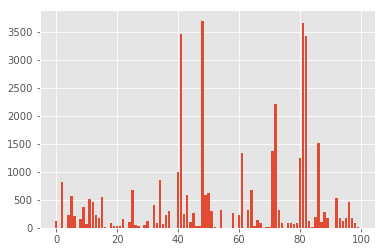

In [97]:

plt.bar( x, y)


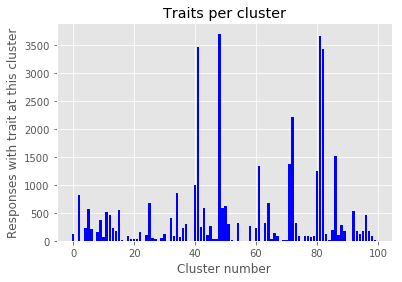

In [98]:
fig, ax = plt.subplots()

rects1 = ax.bar(x, y, color='b')
ax.set_xlabel('Cluster number')
ax.set_ylabel('Responses with trait at this cluster')
ax.set_title('Traits per cluster')



In [99]:
counts_per_cluster = np.bincount(km.labels_)

In [100]:
print (counts_per_cluster)

[  651   128   939    10   234   710   823   126  1681   403   629   366
   453  1316  1850   948   139   136   369  1271    54   802    85   318
  2086  1375    40   348    54   499   569   233   492   532  2611   134
   540   851   288   219  1497  3605   960  2553   494   338   196  1234
 14880  1106  1313  1015   554   366   581    20   142   436   339     0
   802  2032  1129  1278  2234   405  1645   298    70    19   268  2831
  1643  1578   169    44   470   215   449   434  1389  7157  6659   594
    75   320   756   272   292  2821   257    59   561   195    65  1013
  1344   650   298   269]


In [101]:
counts_per_cluster = list(counts_per_cluster)

In [102]:
counts_per_cluster.remove(0)

In [103]:
counts_per_cluster = np.array(counts_per_cluster)

In [104]:
y1 = y / counts_per_cluster

In [105]:
y

cluster_100
0      121
1        0
2      819
3        0
4      230
5      563
6      207
7        4
8      156
9      366
10      68
11     521
12     453
13     232
14     171
15     547
16      15
17       0
18      94
19      40
20      28
21      30
22     151
23       0
24      98
25     674
26      44
27      28
28       0
29      57
      ... 
70      12
71    1372
72    2216
73     321
74      86
75       0
76      84
77      87
78      76
79      82
80    1245
81    3660
82    3430
83     126
84       6
85     201
86    1510
87     101
88     278
89     179
90       0
91       0
92     531
93     169
94     130
95     169
96     466
97     183
98      78
99       7
Length: 99, dtype: int64

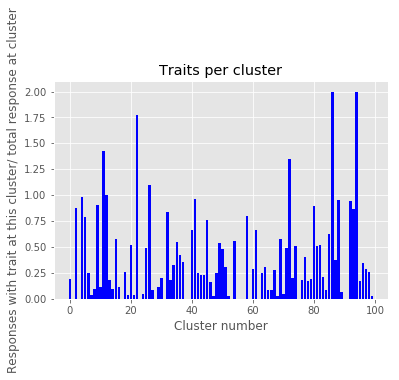

In [106]:
fig, ax = plt.subplots()

rects1 = ax.bar(x, y1, color='b')
ax.set_xlabel('Cluster number')
ax.set_ylabel('Responses with trait at this cluster/ total response at cluster')
ax.set_title('Traits per cluster')